# 3D Sensing & Sensor Fusion  - 2nd assignment - Upsampling

> Name: Tamas Dancs
>
> Neptune code: W5U6VQ

## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

## Subtask 1

- Implement the Bilateral or the Bilateral Median filter, your choice.
- Evaluate the filter on an image of your choice (see below).

### Bilateral filter

In [2]:
@njit
def bilateral_filter(image, window_size, sigma_d, sigma_r):
  height = image.shape[0]
  width = image.shape[1]
  half_window = window_size // 2
  filtered_image = np.zeros(image.shape, image.dtype)
  w = lambda i, j, k, l: np.exp(
    -((np.square(np.subtract(i,k)) + np.square(np.subtract(j,l))) / (2 * np.square(sigma_d)))
    -((np.subtract(image[i,j],image[k,l])) / (2 * np.square(sigma_r)))
  )

  for i in range(height):
    for j in range(width):
      sum = 0.
      sum_weight = 0.

      for k in range(-half_window, half_window+1):
        for l in range(-half_window, half_window+1):
          neighbor_i = i+k
          neighbor_j = j+l
          
          if neighbor_i < 0: neighbor_i = 0
          if neighbor_j < 0: neighbor_j = 0
          if neighbor_i >= height: neighbor_i = height-1
          if neighbor_j >= width: neighbor_j = width-1

          weight = w(i, j, neighbor_i, neighbor_j)
          sum += image[neighbor_i,neighbor_j] * weight
          sum_weight += weight

      filtered_image[i,j] = int(np.round(sum // sum_weight))

  return filtered_image

In [3]:
image = cv2.imread('lenna.png', cv2.IMREAD_GRAYSCALE)
image_bilateral = bilateral_filter(image, window_size=5, sigma_d=3, sigma_r=3)

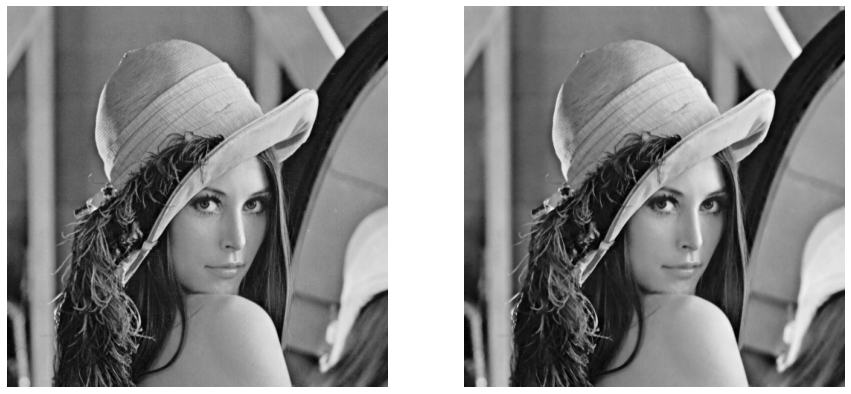

In [4]:
i = 0
plt.figure(figsize=(15, 8))
for image in [image, image_bilateral]:
  plt.subplot(1, 2, i+1)
  plt.axis('off')
  _ = plt.imshow(image, cmap='gray')
  i += 1

### Evaluation

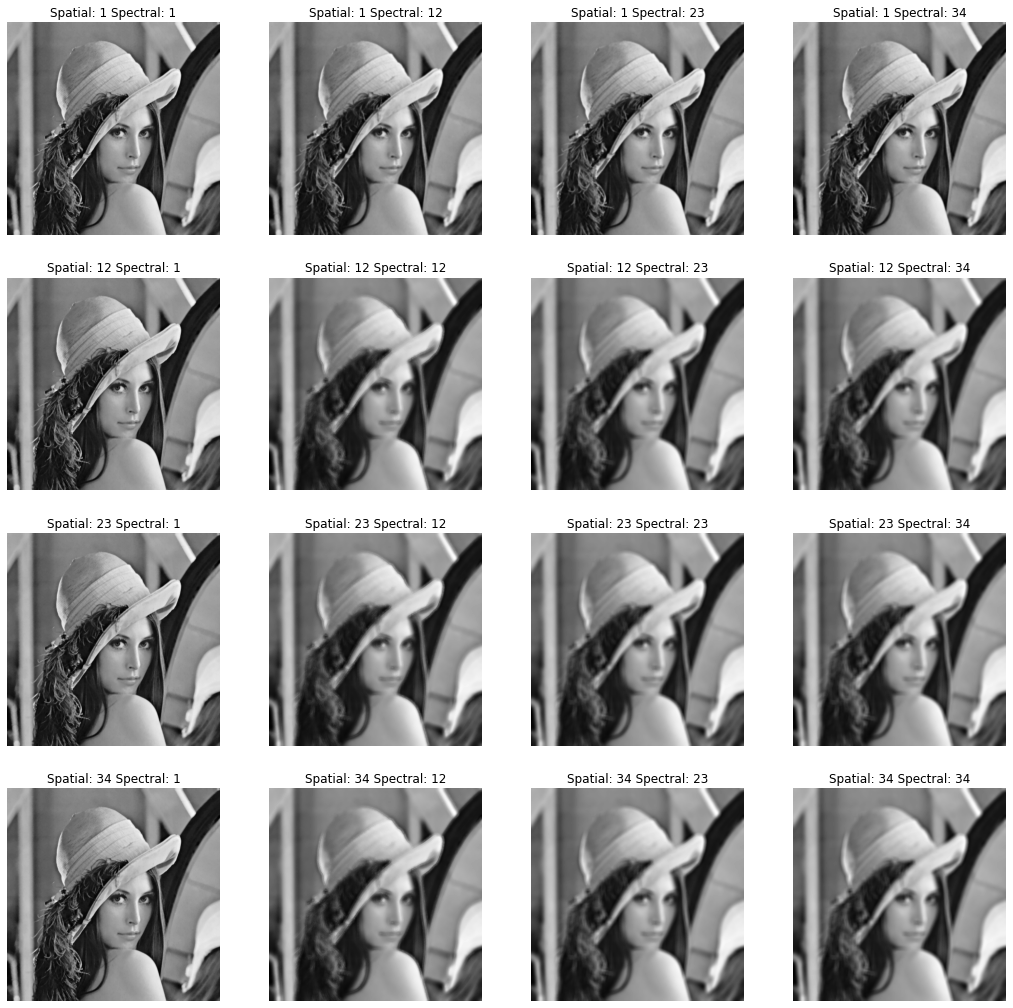

In [5]:
col = 0
plt.figure(figsize=(18,18))
for i in range(4):
  for j in range(4):
    plt.subplot(4, 4, col+1)
    sigma_d = i+1+(i*10)
    sigma_r = j+1+(j*10)

    plt.title(f'Spatial: {sigma_d} Spectral: {sigma_r}')
    img = bilateral_filter(image, window_size=11, sigma_d=sigma_d, sigma_r=sigma_r)
    plt.axis('off')
    _ = plt.imshow(img, cmap='gray')
    col += 1

## Subtask 2

- Convert a bilateral filter to Guided Joint bilateral filter for guided image upsampling.
- Apply the filter to upsample a depth image, guided by an RGB image.

### Joint bilateral filter

In [6]:
@njit
def joint_bilateral_filter(image, guide, window_size, sigma_d, sigma_r):
  height = image.shape[0]
  width = image.shape[1]
  half_window = window_size // 2
  filtered_image = np.zeros(image.shape, image.dtype)
  w = lambda i, j, k, l: np.exp(
    -((np.square(np.subtract(i,k)) + np.square(np.subtract(j,l))) / (2 * np.square(sigma_d)))
    -((np.subtract(guide[i,j],guide[k,l])) / (2 * np.square(sigma_r)))
  )

  for i in range(height):
    for j in range(width):
      sum = 0.
      sum_weight = 0.

      for k in range(-half_window, half_window+1):
        for l in range(-half_window, half_window+1):
          neighbor_i = i+k
          neighbor_j = j+l
          
          if neighbor_i < 0: neighbor_i = 0
          if neighbor_j < 0: neighbor_j = 0
          if neighbor_i >= height: neighbor_i = height-1
          if neighbor_j >= width: neighbor_j = width-1

          weight = w(i, j, neighbor_i, neighbor_j)
          sum += image[neighbor_i,neighbor_j] * weight
          sum_weight += weight

      filtered_image[i,j] = int(np.round(sum // sum_weight))

  return filtered_image

In [14]:
set = 'Cones'
image_path = f'datasets/{set}/im.png'
display_path = f'datasets/{set}/disp.png'

image_depth = cv2.imread(display_path, cv2.IMREAD_GRAYSCALE)
image_guide = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

image_joint_bilateral = joint_bilateral_filter(image_depth, image_guide, window_size=5, sigma_d=3, sigma_r=3)

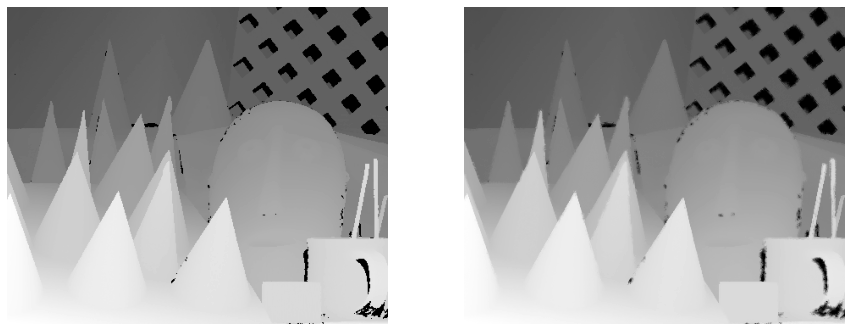

In [15]:
i = 0
plt.figure(figsize=(15, 8))
for image in [image_depth, image_joint_bilateral]:
  plt.subplot(1, 2, i+1)
  plt.axis('off')
  _ = plt.imshow(image, cmap='gray')
  i += 1

### Upsampling

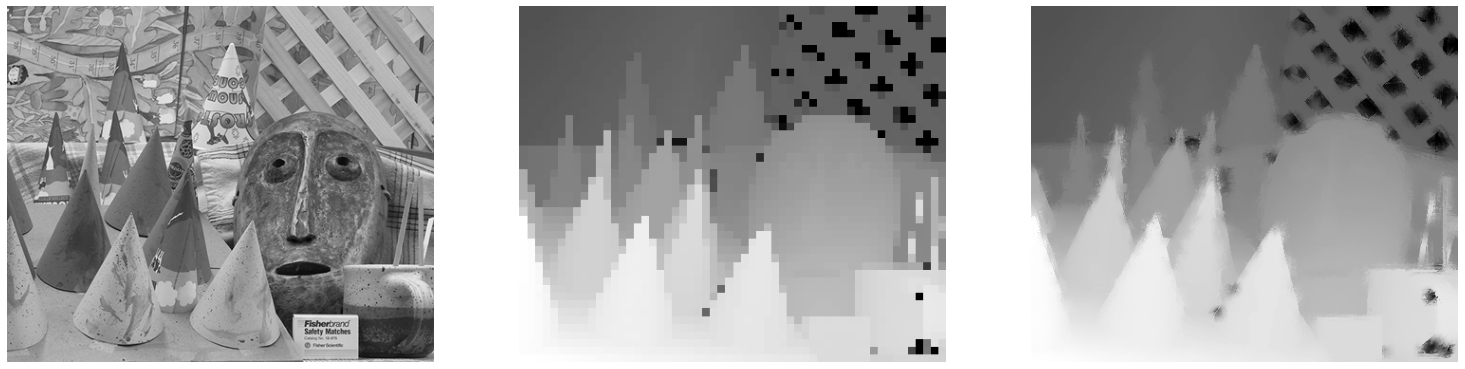

In [17]:
set = 'Cones'
image_path = f'datasets/{set}/im.png'
display_path = f'datasets/{set}/disp.png'

image_depth = cv2.imread(display_path, cv2.IMREAD_GRAYSCALE)
image_guide = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

image_depth_resized = cv2.resize(image_depth, (image_depth.shape[1] // 8, image_depth.shape[0] // 8))
image_depth_resized = cv2.resize(image_depth_resized, (image_guide.shape[1], image_guide.shape[0]), interpolation=cv2.INTER_NEAREST)

image_joint_bilateral = joint_bilateral_filter(image_depth_resized, image_guide, window_size=15, sigma_d=5, sigma_r=2)

i = 0
plt.figure(figsize=(26, 18))
for image in [image_guide, image_depth_resized, image_joint_bilateral]:
  plt.subplot(1, 3, i+1)
  plt.axis('off')
  _ = plt.imshow(image, cmap='gray')
  i += 1

### Iterative approach

In [10]:
def iterative_upsample(input_depth, input_guide, filter_params):
  factor = np.log2(input_guide.shape[0] // input_depth.shape[0])
  iter_depth = input_depth

  for _ in range(int(factor)):
    iter_depth = cv2.resize(iter_depth, (iter_depth.shape[1] * 2, iter_depth.shape[0] * 2), interpolation=cv2.INTER_NEAREST)
    iter_guide = cv2.resize(input_guide, (iter_depth.shape[1], iter_depth.shape[0]))
    iter_depth = joint_bilateral_filter(iter_depth, iter_guide, **filter_params)

  iter_depth = cv2.resize(iter_depth, (input_guide.shape[1], input_guide.shape[0]), interpolation=cv2.INTER_NEAREST)
  return joint_bilateral_filter(iter_depth, input_guide, **filter_params)


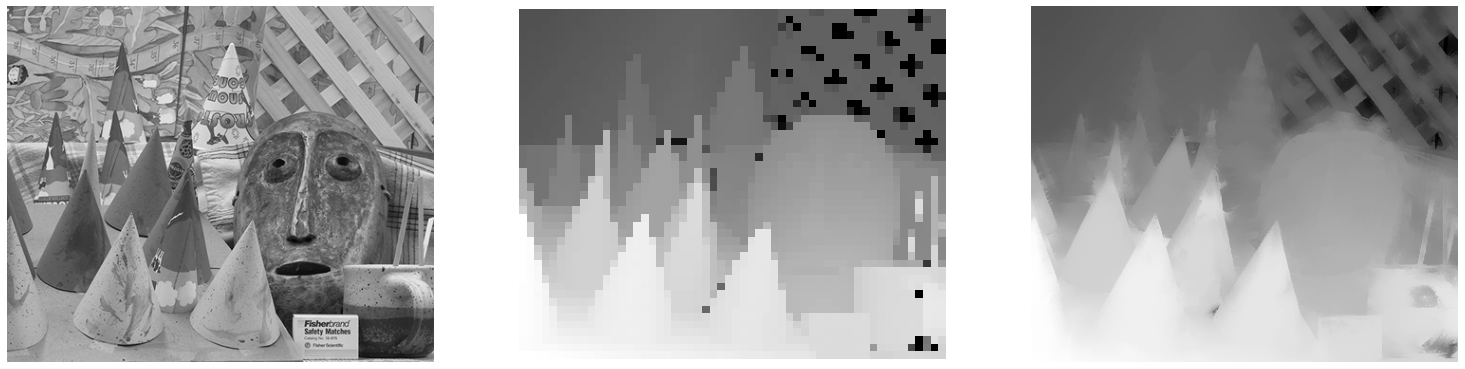

In [18]:
set = 'Cones'
image_path = f'datasets/{set}/im.png'
display_path = f'datasets/{set}/disp.png'

image_depth = cv2.imread(display_path, cv2.IMREAD_GRAYSCALE)
image_guide = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

filter_params = dict(window_size=9, sigma_d=5, sigma_r=2)
image_depth_resized = cv2.resize(image_depth, (image_depth.shape[1] // 8, image_depth.shape[0] // 8))
iter_result = iterative_upsample(image_depth_resized, image_guide, filter_params)

i = 0
plt.figure(figsize=(26, 18))
for image in [image_guide, image_depth_resized, iter_result]:
  plt.subplot(1, 3, i+1)
  plt.axis('off')
  _ = plt.imshow(image, cmap='gray')
  i += 1

## Subtask 3